In [3]:
import os;
import json;
import builtins
import duckdb
import pandas as pd;
import matplotlib.pyplot as plt

def get_dataset_from_testcase(run):
    return run[0:-2]

dir = '/home/chesetti/Repos/KVector_Merge/sponge/join_all'
runs = []
for test_case in os.listdir(dir):
    if test_case == 'build':
        continue
    for run_name in os.listdir(os.path.join(dir, test_case, 'outputs', 'results', 'run')):
        json_file = builtins.open(os.path.join(dir, test_case, 'outputs', 'results', 'run', run_name))
        run = (json.load(json_file))
        run['dataset'] = get_dataset_from_testcase(test_case)
        runs.append(run)
df = pd.json_normalize(runs)
print(df.columns)
display(df)

Index(['command', 'dataset', 'result.checksum', 'result.duration_ns',
       'result.duration_sec', 'result.inner_disk_fetch',
       'result.inner_disk_fetch_size', 'result.inner_total_bytes_fetched',
       'result.outer_disk_fetch', 'result.outer_disk_fetch_size',
       'result.outer_total_bytes_fetched', 'spec.algo', 'spec.algo_name',
       'spec.check_checksum', 'spec.common_key', 'spec.index.epsilon',
       'spec.index.leaf_size_in_pages', 'spec.index.search', 'spec.index.type',
       'spec.inner_table', 'spec.key_size', 'spec.key_type',
       'spec.load_sstable_in_mem', 'spec.name', 'spec.num_threads',
       'spec.outer_table', 'spec.result_path', 'spec.value_size',
       'spec.write_result_to_disk'],
      dtype='object')


,command,dataset,result.checksum,result.duration_ns,result.duration_sec,result.inner_disk_fetch,result.inner_disk_fetch_size,result.inner_total_bytes_fetched,result.outer_disk_fetch,result.outer_disk_fetch_size,...,spec.inner_table,spec.key_size,spec.key_type,spec.load_sstable_in_mem,spec.name,spec.num_threads,spec.outer_table,spec.result_path,spec.value_size,spec.write_result_to_disk
0,sponge/join_all/build/benchmark_runner sponge/...,fb,1BCA711E30554C07B1B7B479090A6E59,2783384802,2.783385,18587,16384,304521488,74348,4096,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,inlj_btree10241run_0,1,sponge/join_all/fb_1/inputs/input1,sponge/join_all/fb_1/outputs/inlj_btree1024_ru...,8,True
1,sponge/join_all/build/benchmark_runner sponge/...,fb,723A3133F15563777E0FCD455E9FF255,28242846,0.028243,4203,69632,292652448,79,4096,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,lsj_pgm40961000run_1,1,sponge/join_all/fb_1/inputs/input1000,sponge/join_all/fb_1/outputs/lsj_pgm4096_run_1...,8,True
2,sponge/join_all/build/benchmark_runner sponge/...,fb,723A3133F15563777E0FCD455E9FF255,28518146,0.028518,4247,69632,295717136,79,4096,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,lsj_sampledflatpgm40961000run_1,1,sponge/join_all/fb_1/inputs/input1000,sponge/join_all/fb_1/outputs/lsj_sampledflatpg...,8,True
3,sponge/join_all/build/benchmark_runner sponge/...,fb,C3916A491063339306CE0AE8B424F3EB,53426979,0.053427,14821,20480,303523648,781,4096,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,lsj_flatpgm1024100run_3,1,sponge/join_all/fb_1/inputs/input100,sponge/join_all/fb_1/outputs/lsj_flatpgm1024_r...,8,True
4,sponge/join_all/build/benchmark_runner sponge/...,fb,C3916A491063339306CE0AE8B424F3EB,112146969,0.112147,56170,20480,1150349584,781,4096,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,inlj_sampledflatpgm1024100run_3,1,sponge/join_all/fb_1/inputs/input100,sponge/join_all/fb_1/outputs/inlj_sampledflatp...,8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,sponge/join_all/build/benchmark_runner sponge/...,fb,C3916A491063339306CE0AE8B424F3EB,92643925,0.092644,40660,20480,832698720,781,4096,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,inlj_pgm1024100run_0,1,sponge/join_all/fb_1/inputs/input100,sponge/join_all/fb_1/outputs/inlj_pgm1024_run_...,8,True
412,sponge/join_all/build/benchmark_runner sponge/...,fb,723A3133F15563777E0FCD455E9FF255,478152873,0.478153,74337,4096,304484352,79,4096,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,sort_join1000run_0,1,sponge/join_all/fb_1/inputs/input1000,sponge/join_all/fb_1/outputs/sort_join_run_0_r...,8,True
413,sponge/join_all/build/benchmark_runner sponge/...,fb,C3916A491063339306CE0AE8B424F3EB,57740909,0.057741,14821,20480,303523648,781,4096,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,lsj_pgm1024100run_3,1,sponge/join_all/fb_1/inputs/input100,sponge/join_all/fb_1/outputs/lsj_pgm1024_run_3...,8,True
414,sponge/join_all/build/benchmark_runner sponge/...,fb,C3916A491063339306CE0AE8B424F3EB,56896899,0.056897,14821,20480,303523648,781,4096,...,sponge/join_all/fb_1/inputs/inner,8,uint64,False,lsj_pgm1024100run_2,1,sponge/join_all/fb_1/inputs/input100,sponge/join_all/fb_1/outputs/lsj_pgm1024_run_2...,8,True


In [4]:

epsilon = {
    "pgm256": 256,
    "pgm1024": 1024,
    "pgm2048": 2048,
    "flatpgm256": 256,
    "flatpgm1024": 1024,
    "flatpgm2048": 2048,
    "flatpgm4096": 4096,
    "flatpgm8192": 8192,
    "hashjoin": 0,
    "btree": 0,
    "sj": 0,
    "sj2": 0,
    "standard_merge": 0
};
def indexType(x):
    if "pgm" in x:
        return "PGM"
    elif "btree" in x:
        return "BTREE"
    return "NA"

df["threads"] = df["spec.num_threads"]
df["duration_sec"] = df["result.duration_ns"] / (1000000000)
df["ratio"] = df["spec.common_key"]
df["algo"] = df["spec.algo_name"]
df["epsilon"] = df["spec.index.epsilon"]
df["inner_bytes_fetched"] = df["result.inner_total_bytes_fetched"]
df["index_type"] = df["spec.algo_name"].map(lambda x: indexType(x))
df['dataset'].unique()


array(['fb'], dtype=object)

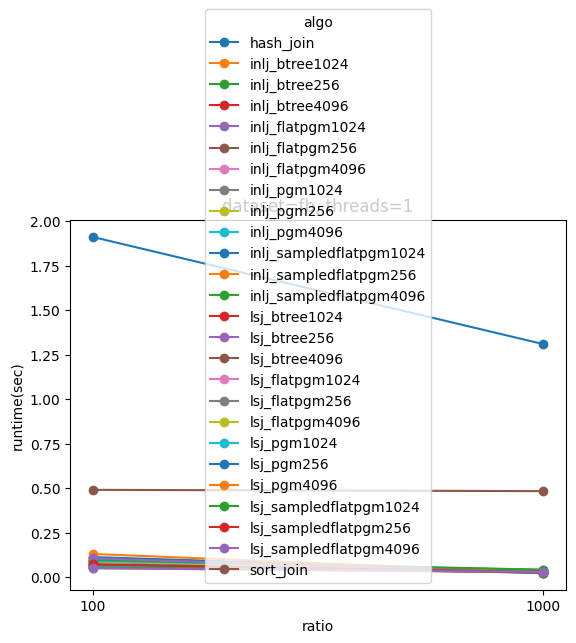

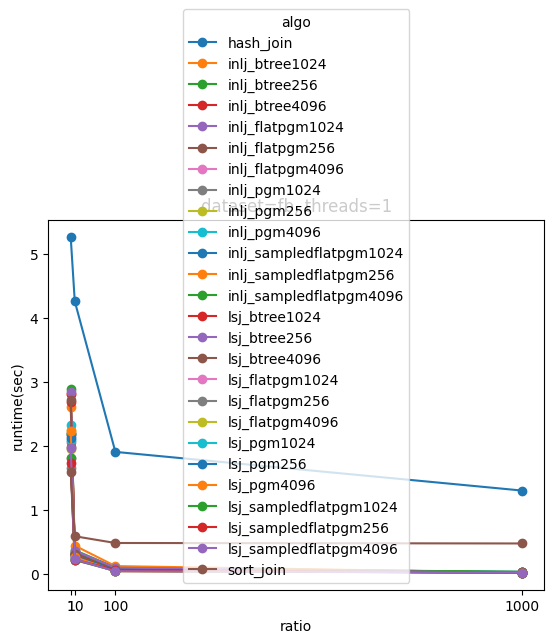

In [5]:
def plot_for_dataset_zoomed(dataset, threads):
    rows = duckdb.sql(
        " SELECT threads, ratio, algo, AVG(duration_sec) as v FROM df"
        f" WHERE dataset='{dataset}' AND algo != 'hj' AND ratio>=50 AND threads={threads}"
        " GROUP BY dataset, threads, ratio, algo"
        " ORDER BY ratio, threads"
    ).df()
    rows = rows.pivot(index='ratio', values='v', columns=['algo'])
    rows.plot(marker='o')
    plt.xlabel('ratio')
    plt.ylabel('runtime(sec)')
    plt.xticks(rows.index)
    plt.title(f'dataset={dataset}, threads={threads}')

def plot_for_dataset(dataset, threads):
    rows = duckdb.sql(
        " SELECT threads, ratio, algo, AVG(duration_sec) as v FROM df"
        f" WHERE dataset='{dataset}' AND threads={threads}"
        " GROUP BY dataset, threads, ratio, algo"
        " ORDER BY ratio, threads"
    ).df()
    rows = rows.pivot(index='ratio', values='v', columns=['algo'])
    rows.plot(marker='o')
    plt.xlabel('ratio')
    plt.ylabel('runtime(sec)')
    plt.xticks(rows.index)
    plt.title(f'dataset={dataset}, threads={threads}')

plot_for_dataset_zoomed('fb', 1)
plot_for_dataset('fb', 1)

In [13]:
rows = duckdb.sql(
    " SELECT ratio, algo, MEDIAN(duration_sec) as v FROM df"
    f" WHERE threads=1 AND (algo='hash_join' OR algo='sort_join' or epsilon='256') AND dataset='fb'"
    " GROUP BY dataset, threads, ratio, algo"
    " ORDER BY ratio, threads"
).df()
display(rows.pivot(index='ratio', values='v', columns='algo'))

rows = duckdb.sql(
    " SELECT ratio, algo, MEDIAN(duration_sec) as v FROM df"
    f" WHERE threads=1 AND (algo='hash_join' OR algo='sort_join' or epsilon='1024') AND dataset='fb'"
    " GROUP BY dataset, threads, ratio, algo"
    " ORDER BY ratio, threads"
).df()

rows = duckdb.sql(
    " SELECT ratio, algo, MEDIAN(duration_sec) as v FROM df"
    f" WHERE threads=1 AND (algo='hash_join' OR algo='sort_join' or epsilon='4096') AND dataset='fb'"
    " GROUP BY dataset, threads, ratio, algo"
    " ORDER BY ratio, threads"
).df()
display(rows.pivot(index='ratio', values='v', columns='algo'))


algo,hash_join,inlj_btree256,inlj_flatpgm256,inlj_pgm256,inlj_sampledflatpgm256,lsj_btree256,lsj_flatpgm256,lsj_pgm256,lsj_sampledflatpgm256,sort_join
ratio,,,,,,,,,,
1,5.264968,2.887879,1.992540,2.247669,2.611206,2.842701,1.657021,2.123189,1.730607,1.592195
10,4.247381,0.377085,0.305954,0.333122,0.447433,0.369119,0.223837,0.272092,0.231095,0.595476
100,1.870138,0.104896,0.085949,0.088996,0.129416,0.104607,0.067580,0.072812,0.070400,0.490316
1000,1.314017,0.023028,0.023826,0.024102,0.027120,0.023387,0.023039,0.023863,0.025803,0.480778


algo,hash_join,inlj_btree1024,inlj_flatpgm1024,inlj_pgm1024,inlj_sampledflatpgm1024,lsj_btree1024,lsj_flatpgm1024,lsj_pgm1024,lsj_sampledflatpgm1024,sort_join
ratio,,,,,,,,,,
1,5.264968,2.788276,2.056217,2.202108,2.196534,2.680747,1.804089,2.089868,1.825317,1.592195
10,4.247381,0.329631,0.295165,0.310508,0.346827,0.318359,0.224125,0.255203,0.227143,0.595476
100,1.870138,0.068156,0.089979,0.092409,0.112339,0.067216,0.053690,0.057319,0.054991,0.490316
1000,1.314017,0.028663,0.028566,0.028930,0.031540,0.028758,0.026841,0.027107,0.028859,0.480778
